- Changed Dropout Values
- Modified Architecture
  - 
- Considering to change LR rate and decay rate, Not changed
Total Param : 35,387



## Installs, imports and Boilerplate code

In [0]:
import warnings
warnings.filterwarnings(action='once')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Convolution2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.utils import np_utils
from keras import backend as K

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/backend.py:5747: ResourceWarning: unclosed file <_io.TextIOWrapper name='/root/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  ret

In [6]:
# loading and configuring cifar10 dataset
from keras.datasets import cifar10

# x_train/test : train/test features
# y_train/test : train/test labels
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols = x_train.shape
num_test = x_test.shape[0]
num_classes = len(np.unique(y_train))

170500096/170498071 [==============================] - 3s 0us/step


In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat',  
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
# https://stackoverflow.com/questions/45965007/multiline-f-string-in-python
print(f"""Train images : {num_train}
Test images : {num_test}
Total classes : {num_classes}
Input image shape : {x_train.shape[1:]}
""")

Train images : 50000
Test images : 10000
Total classes : 10
Input image shape : (32, 32, 3)



In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

In [0]:
def plot_model_history(model_history):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  # summarize history for accuracy
  ax[0].plot(range(1, len(model_history.history['acc'])+1), model_history.history['acc'])#, label='Training Acc')
  ax[0].plot(range(1, len(model_history.history['val_acc'])+1), model_history.history['val_acc'])#, label='Validation Acc')
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xticks(np.arange(1, len(model_history.history['acc'])+1), len(model_history.history['acc'])/10)
  ax[0].legend(['Train', 'Validation'], loc='best')

  # summarize history for loss
  ax[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
  ax[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
  ax[1].legend(['Train', 'Validation'], loc='best')

  plt.show()

In [0]:
def accuracy(test_x, test_y, model):
  result = model.predict(test_x)
  predicted = np.argmax(result, axis=1)
  true = np.argmax(test_y, axis=1)
  num_correct = np.sum(predicted == true)
  accuracy = float(num_correct)/result.shape[0]
  return (accuracy * 100)

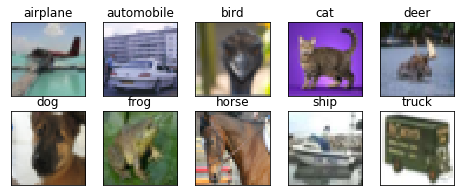

In [12]:
# Checking images, one for each class
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
  ax = fig.add_subplot(2, 5, 1+i, xticks=[], yticks=[])
  idx = np.where(y_train[:]==i)[0]  # selecting all images of a class
  features = x_train[idx,::]
  img_num = np.random.randint(features.shape[0]) # selecting random no. from class idx
  im = features[img_num]  # selecting features of the image from random no.
  ax.set_title(class_names[i])
  plt.imshow(im)
plt.show()

In [0]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# converting class labels to one hot encoded
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

## Model

In [15]:
# Define the model
model = Sequential() 
model.add(SeparableConv2D(32, 3, use_bias=False, padding='same', input_shape=(32, 32, 3))) # 32x3x3x32 RF:3 # padding==border_mode(old version)
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))

model.add(SeparableConv2D(64, 3, use_bias=False, padding='same')) # 32x3x3x64 RF:3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))

model.add(SeparableConv2D(128, 3, use_bias=False)) # 30x3x3x128 RF:3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(SeparableConv2D(256, 3, use_bias=False)) # 28x3x3x256 RF:3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(MaxPooling2D(2)) # 14x3x3x128
model.add(Convolution2D(32, 1, use_bias=False))  # 14x3x3x32

model.add(SeparableConv2D(32, 3, use_bias=False)) # 14x3x3x32
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(SeparableConv2D(64, 3, use_bias=False)) # 12x3x3x64 RF:3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(SeparableConv2D(128, 3, use_bias=False)) # 10x3x3x128 RF:3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(MaxPooling2D(2)) # 4x3x3x128
model.add(Convolution2D(32, 1, use_bias=False))  # 4x3x3x32

model.add(SeparableConv2D(10, 3, use_bias=False)) # 2x3x3x20 RF:3
model.add(GlobalAveragePooling2D()) # 1X10
model.add(Activation('softmax'))

model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 32, 32, 32)        123       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 32, 32, 64)        2336      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0   

In [0]:
# Compile the model
model.compile(optimizer=Adam(lr=0.003), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

In [0]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 validation_data = (x_test, y_test),callbacks=[LearningRateScheduler(scheduler, verbose=1)], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=50)`
  """




Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 77s 197ms/step - loss: 1.3218 - acc: 0.5281 - val_loss: 1.2873 - val_acc: 0.5877
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 70s 180ms/step - loss: 0.9571 - acc: 0.6597 - val_loss: 0.9057 - val_acc: 0.6835
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 70s 180ms/step - loss: 0.8217 - acc: 0.7085 - val_loss: 1.1206 - val_acc: 0.6086
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 70s 180ms/step - loss: 0.7436 - acc: 0.7377 - val_loss: 0.8529 - val_acc: 0.7049
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 70s 179ms/step - loss: 0.6817 - acc:

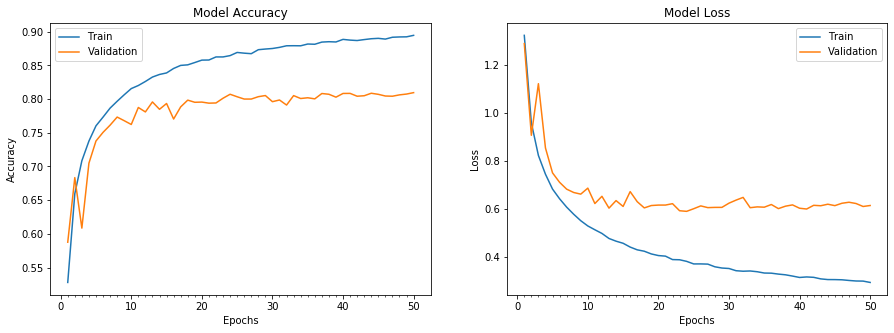

In [0]:
# plot model history
plot_model_history(model_info)

In [0]:
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(x_test, y_test, model))

Accuracy on test data is: 80.95


In [16]:
# Compile the model
model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
def scheduler(epoch, lr):
  return round(0.01 * 1/(1 + 0.319 * epoch), 10)

In [20]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 validation_data = (x_test, y_test),callbacks=[LearningRateScheduler(scheduler, verbose=1)], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=50)`
  """




Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
390/390 [==============================] - 35s 89ms/step - loss: 1.3953 - acc: 0.4968 - val_loss: 2.6669 - val_acc: 0.4306
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0075815011.
390/390 [==============================] - 29s 74ms/step - loss: 1.0097 - acc: 0.6395 - val_loss: 1.2149 - val_acc: 0.6227
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0061050061.
390/390 [==============================] - 29s 74ms/step - loss: 0.8654 - acc: 0.6922 - val_loss: 1.1465 - val_acc: 0.6230
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.005109862.
390/390 [==============================] - 29s 75ms/step - loss: 0.7727 - acc: 0.7295 - val_loss: 0.9651 - val_acc: 0.6833
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0043936731.
390/390 [==============================] - 29s 74ms/step - loss: 0.7058 - acc: 0.7507

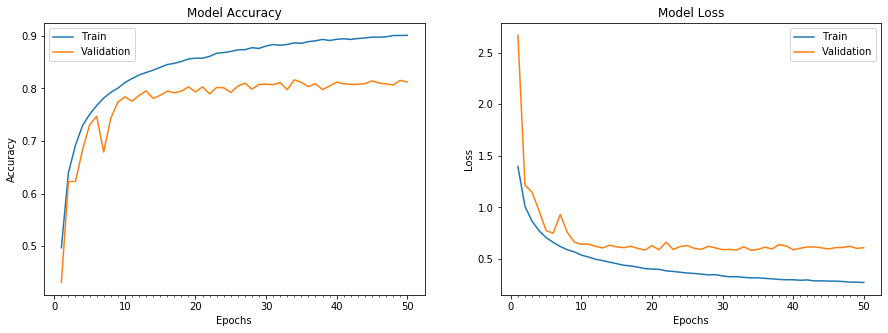

In [21]:
# plot model history
plot_model_history(model_info)

In [22]:
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(x_test, y_test, model))

Accuracy on test data is: 81.25
